<a href="https://colab.research.google.com/github/manelleyva/03.-Algoritmos-de-Optimizacion-2023/blob/main/Trabajo_Practico_Sesiones_de_Doblaje.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Libraries Import
import itertools
import pandas as pd
import numpy as np
import random
import math

# Algoritmos de optimización - Seminario

Nombre: Manel Leyva Martínez

Github: https://github.com/manelleyva/03.-Algoritmos-de-Optimizacion-2023

Problema:
> 1. Sesiones de doblaje <br>

Se precisa coordinar el doblaje de una película. Los actores del doblaje deben coincidir en las
tomas en las que sus personajes aparecen juntos en las diferentes tomas. Los actores de
doblaje cobran todos la misma cantidad por cada día que deben desplazarse hasta el estudio de
grabación independientemente del número de tomas que se graben. No es posible grabar más
de 6 tomas por día. El objetivo es planificar las sesiones por día de manera que el gasto por los
servicios de los actores de doblaje sea el menor posible. Los datos son:

Número de actores: 10
Número de tomas: 30

....

(*) La respuesta es obligatoria                               

### Question 1

(\*)¿Cuantas posibilidades hay sin tener en cuenta las restricciones?


Respuesta

En el caso de que no existieran limitaciones (no existe un máximo de tomas por día), el número de posibilidades sería el siguiente:

$$
Number\ of \ possibilities =
\sum_{j=1}^{Total\ Takes}
\prod_{i=0}^{⌊ (Total\ Takes/j)⌋ -1}\binom{Total\ Takes-i·j}{j} =
\sum_{j=1}^{30}
\prod_{i=0}^{⌊(30/j)⌋-1}\binom{30-i·j}{j} =
2.65·10^{32}
$$

$j$ : Maximum takes per day

$i$ : Day value (starts at 0)

Esto es el sumatorio de todos los posibles tamaños de máximas tomas diarias desde el 1 hasta el 30, por el productorio de combinación sin repetición de las tomas posibles para cada día. En cuanto al productorio, calculamos el número de días como la división entera entre las tomas totales y el máximo de tomas diarias.

En este caso no se está teniendo en cuenta que el orden de los días no afecta al resultado.

El código a continuación ha sido utilizado para calcular el total de posibilidades.

In [2]:
total_possibilities = 0
for j in range(1, 31):
  possibilities_group = 1
  for i in range(int(30/j)):
    possibilities_group = possibilities_group*math.comb(30-i*j,j)
  total_possibilities += possibilities_group

print(f'There are {total_possibilities:.2e} possibilities')

There are 2.65e+32 possibilities


### Question 2
¿Cuantas posibilidades hay teniendo en cuenta todas las restricciones.

Respuesta

Teniendo en cuenta las resticciones el número de posibilidades es:

$$Number\ of \ possibilities =
\frac{\prod_{i=0}^{Days-1}\binom{Takes-i·Takes/Days}{Takes/Days}}{Days!} =
\frac{\prod_{i=0}^{4}\binom{30-i·6}{6}}{5!}=1.142·10^{16}$$

Esta fórmula es una simplificación de la versión sin restricciones. Cada día tenemos la opción de escoger entre las tomas restantes, un grupo de 6 tomas. Esto es la multiplicación de la combinatoria de tomas hasta que no queden tomas restantes.

Debido a que el orden de los días no afecta al resultado, se divide este resultado entre el factorial del número de días (permutación sin repetición).

En este análisis se está ignorando la posibilidad de grabar menos de 6 tomas por día ya que esto no proporcionaría ninguna ventaja.

## Modelo para el espacio de soluciones<br>

### Question 3

(*) ¿Cual es la estructura de datos que mejor se adapta al problema? Argumentalo.(Es posible que hayas elegido una al principio y veas la necesidad de cambiar, arguentalo)


Respuesta

Actualmente el modelo utiliza un dataframe de pandas con una columna por cada día de grabación. En nuestro caso, tenemos 5 columnas de días ($Número\ Días = \frac{Total\ Tomas}{Máximo\ Tomas\ Diarias}=\frac{30}{6}=5$).

En estas columnas se almacenan listas de las tomas seleccionadas para ese día. Asimismo, tenemos una columna adicional que indica el coste total para la planificación de todas las sesiones.

Esta estructura de datos permite ver de manera clara cómo se van a organizar las sesiones y el coste total de cada opción. Gracias eficiencia de pandas dataframe respecto a las estructuras de datos estándar en python, podemos operar sobre conjuntos con gran cantidad de datos en un tiempo de ejecución relativamente bajo.

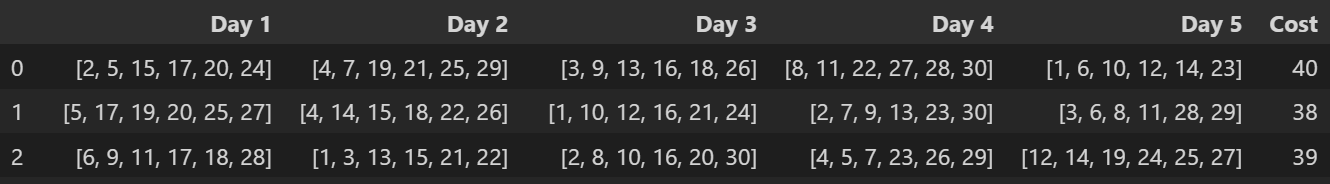

*Fig. 1: Ejemplo de la estructura de datos propuesta para el ejercicio*

Sin embargo, otra posible implementación sería utilizar "grafos bipartitos ponderados". Se puede utilizar un grafo para representar la relación entre los actores, de manera que los nodos representen los actores y las aristas que los conectan, el coste para que trabajen juntos.

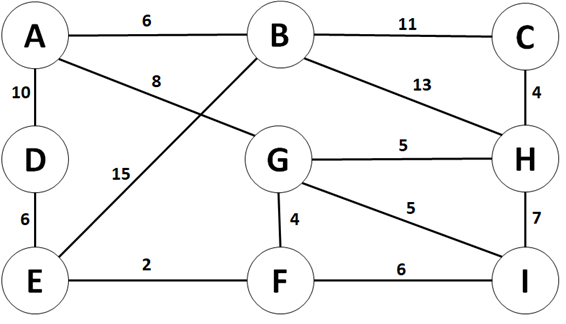

*Fig. 2: Ejemplo de grafo ponderado*

Pese a que la estructura de grafos podría haber dado buenos resultados, se optó por el dataframe debido a su simplicidad de implementación para un algoritmo genético.

Según el modelo para el espacio de soluciones<br>

### Question 4

(*)¿Cual es la función objetivo?

Respuesta:

La función objetivo es minimizar el costo total de los servicios de los actores de doblaje, cumpliendo la restricción de no grabar más de 6 tomas al día. Queremos encontrar una asignación de las tomas a los actores de doblaje que minimice el costo diario.

La función objetivo se puede expresar de la siguiente manera:

$$Total\ Cost = \sum_{i=1}^{Number\ days} Cd_i = \sum_{i=1}^{5} Cd_i$$

$Number\ days = Total\ takes / Maximum\ takes\ per\ day = 30/6 = 5$

$Cd_i$ : Coste diario. Función que devuelve el coste de un día dependiendo de las tomas escogidas para ese día y los actores necesarios para realizarlas.

### Question 5

(*)¿Es un problema de maximización o minimización?

Respuesta

Es un problema de minimización, ya que el objetivo es conseguir el coste más pequeño por grabar todas las tomas.

### Question 6

Diseña un algoritmo para resolver el problema por fuerza bruta

Respuesta

Para poder diseñar un algoritmo que resuelva el problema por fuerza bruta, tenemos que obtener todas las opciones posibles.

Con la función get_take_combinations() podemos generar un dataframe con todas las posibles combinaciones dependiendo del número de tomas totales y el máximo de tomas por día.

In [3]:
# Get all the takes possibilities
def get_take_combinations():
    # Initialize results dataframe
    df_columns = [f'Day {day}' for day in range(1, TOTAL_DAYS+1)] + ['Cost']
    df = pd.DataFrame(columns=df_columns)


    permutations_iter = itertools.permutations(range(1,TOTAL_TAKES+1), TOTAL_TAKES) # Get all permutations
    for permutation in permutations_iter:
        combination = [list(sorted(permutation[i:i + TAKES_PER_DAY])) for i in range(0, len(permutation), TAKES_PER_DAY)]

        # Subdivide the takes into different days
        data_df = {}
        for idx, i in enumerate(range(0, len(permutation), TAKES_PER_DAY)):
            day = idx+1
            data_df[f'Day {day}'] = sorted(permutation[i:i + TAKES_PER_DAY])

        # Add new value to dataframe
        df = pd.concat([df, pd.DataFrame([data_df])], ignore_index=True)

    # Remove duplicate rows
    df = df.iloc[df.astype(str).drop_duplicates().index]

    return df

In [4]:
# Test Function

# Variable declaration
TOTAL_TAKES = 4
TAKES_PER_DAY = 2
TOTAL_DAYS = int(TOTAL_TAKES/TAKES_PER_DAY)

# Display Results
df_brute_force = get_take_combinations()
display(df_brute_force)
print(f'Number of options: {len(df_brute_force)}')

,Day 1,Day 2,Cost
0,"[1, 2]","[3, 4]",NaN
2,"[1, 3]","[2, 4]",NaN
4,"[1, 4]","[2, 3]",NaN
8,"[2, 3]","[1, 4]",NaN
10,"[2, 4]","[1, 3]",NaN
16,"[3, 4]","[1, 2]",NaN


Number of options: 6


Una vez calculadas todas las combinaciones simplemente tenemos que calcular el coste de cada opción.

Necesitamos entonces cargar el dataframe con los actores necesarios para cada toma.

In [6]:
# Load .csv file
df_actors = pd.read_csv('data_simplified.csv', sep=';', index_col=0)

Una vez cargado el dataframe, podemos calcular el coste total de una opción creando 2 funciones: Una que calcule el coste de un día y otra que calcule el coste total (la suma de todos los días). Nuestro resultado final será el que tenga el valor más pequeño en la columna de coste del dataframe.

In [7]:
# Calculate cost day
def calculate_cost_day(takes_list):
    df_filtered = df_actors[df_actors.index.isin(takes_list)]

    # Calculate cost (if col has 1, add 1 to cost)
    cost = (df_filtered == 1).any().sum()

    return cost

# Calculates the total cost of all sessions
def calculate_cost_total(row):
    total_cost = 0
    for day in range(1, len(row)):
        total_cost += calculate_cost_day(row[f'Day {day}'])
    return total_cost

# Updates the cost column in the population dataframe
def update_cost_dataframe(df):
    df['Cost'] = df.apply(calculate_cost_total, axis=1)
    return df

# Returns the best option in the dataframe
def get_best_take_option(df):
    return pd.DataFrame([ df.iloc[df['Cost'].idxmin()] ])

In [8]:
# Test Function

# Calculate cost for each element in population
df_brute_force = update_cost_dataframe(df_brute_force)

# Display results
display(df_brute_force)

# Get best result
print('\nThe best result is the following:')
display(get_best_take_option(df_brute_force))

,Day 1,Day 2,Cost
0,"[1, 2]","[3, 4]",10
2,"[1, 3]","[2, 4]",13
4,"[1, 4]","[2, 3]",12
8,"[2, 3]","[1, 4]",12
10,"[2, 4]","[1, 3]",13
16,"[3, 4]","[1, 2]",10



The best result is the following:


,Day 1,Day 2,Cost
0,"[1, 2]","[3, 4]",10


Los ejemplos anteriores se han realizado un total de tomas y máximo de tomas por días inferior al valor del problema. Esto es debido a que el problema real es computacionalmente muy exigente y comprobar el resultado requeriría decenas de horas.

In [ ]:
# Variable declaration
TOTAL_TAKES = 30
TAKES_PER_DAY = 6
TOTAL_DAYS = int(TOTAL_TAKES/TAKES_PER_DAY)

# Get all combinations
df_brute_force = get_take_combinations()

# Calculate cost for each element in population
df_brute_force = update_cost_dataframe(df_brute_force)

# Get best result
print('The best result is the following:')
display(get_best_take_option(df_brute_force))

El código anterior nos permitiría conseguir una solución exacta al problema, pero no ha sido posible ejecutarlo completamente debido a su largo tiempo de ejecución.

### Question 7

Calcula la complejidad del algoritmo por fuerza bruta

Respuesta

### Question 8

(*)Diseña un algoritmo que mejore la complejidad del algortimo por fuerza bruta. Argumenta porque crees que mejora el algoritmo por fuerza bruta

Respuesta

Para mejorar la eficiencia del algoritmo por fuerza bruta he propuesto la creación de un algoritmo genético. Pese a no obtener el mejor resultado, los algoritmos genéticos han demostrado ser capaces de encontrar soluciones aceptables en un tiempo mucho más reducido.

Para poder implementar el algoritmo genético necesitamos implementar algunas funciones nuevas. Necesitamos una función de inicialización que cree una población inicial de manera completamente aleatoria.

In [ ]:
# Initialize random population
def initialize_random_population(population_size):
    days = int(TOTAL_TAKES/TAKES_PER_DAY)

    # Initialize results dataframe
    df_columns = [f'Day {day}' for day in range(1, days+1)] + ['Cost']
    df = pd.DataFrame(columns=df_columns)

    for _ in range(population_size):
        takes = list(range(1, TOTAL_TAKES+1))
        random.shuffle(takes) # Randomize the order of the takes

        # Subdivide the takes into different days
        data_df = {}
        for idx, i in enumerate(range(0, len(takes), TAKES_PER_DAY)):
            day = idx+1
            data_df[f'Day {day}'] = sorted(takes[i:i + TAKES_PER_DAY])

        # Add new value to dataframe
        df = pd.concat([df, pd.DataFrame([data_df])], ignore_index=True)

    # Calculate cost for each element in population
    df = update_cost_dataframe(df)

    return df

In [ ]:
# Test function

# Variable declaration
population_size = 10
TOTAL_TAKES = 30
TAKES_PER_DAY = 6
TOTAL_DAYS = int(TOTAL_TAKES/TAKES_PER_DAY)

# Display results
df_population = initialize_random_population(population_size)
display(df_population)

,Day 1,Day 2,Day 3,Day 4,Day 5,Cost
0,"[2, 5, 15, 17, 20, 24]","[4, 7, 19, 21, 25, 29]","[3, 9, 13, 16, 18, 26]","[8, 11, 22, 27, 28, 30]","[1, 6, 10, 12, 14, 23]",40
1,"[5, 17, 19, 20, 25, 27]","[4, 14, 15, 18, 22, 26]","[1, 10, 12, 16, 21, 24]","[2, 7, 9, 13, 23, 30]","[3, 6, 8, 11, 28, 29]",38
2,"[6, 9, 11, 17, 18, 28]","[1, 3, 13, 15, 21, 22]","[2, 8, 10, 16, 20, 30]","[4, 5, 7, 23, 26, 29]","[12, 14, 19, 24, 25, 27]",39
3,"[3, 18, 24, 25, 29, 30]","[8, 13, 16, 17, 26, 27]","[1, 2, 7, 10, 20, 22]","[4, 6, 12, 15, 21, 23]","[5, 9, 11, 14, 19, 28]",38
4,"[4, 14, 17, 21, 23, 28]","[2, 3, 7, 13, 15, 27]","[6, 11, 12, 19, 20, 24]","[1, 8, 9, 18, 22, 26]","[5, 10, 16, 25, 29, 30]",35
5,"[4, 15, 19, 24, 26, 30]","[6, 8, 14, 16, 27, 28]","[12, 17, 18, 20, 23, 25]","[2, 9, 10, 21, 22, 29]","[1, 3, 5, 7, 11, 13]",38
6,"[7, 13, 17, 26, 29, 30]","[5, 8, 14, 16, 19, 28]","[2, 6, 12, 18, 21, 25]","[3, 9, 10, 20, 23, 27]","[1, 4, 11, 15, 22, 24]",38
7,"[7, 17, 19, 22, 23, 29]","[1, 3, 8, 9, 15, 26]","[2, 5, 13, 16, 20, 24]","[4, 6, 12, 14, 18, 21]","[10, 11, 25, 27, 28, 30]",39
8,"[10, 13, 22, 27, 28, 30]","[6, 8, 18, 19, 20, 29]","[2, 5, 12, 15, 21, 24]","[3, 9, 14, 17, 23, 26]","[1, 4, 7, 11, 16, 25]",37
9,"[2, 14, 15, 18, 21, 29]","[6, 12, 17, 24, 25, 28]","[1, 5, 7, 8, 20, 26]","[4, 10, 13, 19, 23, 30]","[3, 9, 11, 16, 22, 27]",40


Una vez creada la población, necesitamos un método de selección natural que escoja los mejores individuos y elimine los peores. En este caso los mejores individuos tendrán un coste más bajo y los peores más alto.

In [ ]:
# Select best individuals from population (lowest cost)
def natural_selection(df_population):
    # Sort population by lowest cost
    df_population = df_population.sort_values(by='Cost', ascending=True)

    # Select the better half
    half_point = int(len(df_population)/ 2)
    df_population = df_population.iloc[:half_point]
    return df_population

In [ ]:
# Test function
df_population = natural_selection(df_population)
display(df_population)

,Day 1,Day 2,Day 3,Day 4,Day 5,Cost
4,"[4, 14, 17, 21, 23, 28]","[2, 3, 7, 13, 15, 27]","[6, 11, 12, 19, 20, 24]","[1, 8, 9, 18, 22, 26]","[5, 10, 16, 25, 29, 30]",35
8,"[10, 13, 22, 27, 28, 30]","[6, 8, 18, 19, 20, 29]","[2, 5, 12, 15, 21, 24]","[3, 9, 14, 17, 23, 26]","[1, 4, 7, 11, 16, 25]",37
1,"[5, 17, 19, 20, 25, 27]","[4, 14, 15, 18, 22, 26]","[1, 10, 12, 16, 21, 24]","[2, 7, 9, 13, 23, 30]","[3, 6, 8, 11, 28, 29]",38
3,"[3, 18, 24, 25, 29, 30]","[8, 13, 16, 17, 26, 27]","[1, 2, 7, 10, 20, 22]","[4, 6, 12, 15, 21, 23]","[5, 9, 11, 14, 19, 28]",38
5,"[4, 15, 19, 24, 26, 30]","[6, 8, 14, 16, 27, 28]","[12, 17, 18, 20, 23, 25]","[2, 9, 10, 21, 22, 29]","[1, 3, 5, 7, 11, 13]",38


Para poder crear una nueva generación, necesitamos un método que cree un nuevo "hijo" a partir de 2 de las mejores opciones. En este caso escogeremos tomas aleatoriamente de los dos padres (uniform crossover). Para evitar la repetición de tomas, en caso de que no se puede añadir una toma a un día concreto porque ya se ha utilizado en otro día, se añadirá una toma aleatoria de las restantes.

In [ ]:
# Create child
def create_child(parent1, parent2):
    # Execute exception if both parents are different sizes
    if len(parent1) != len(parent2):
        raise Exception('Both parents must be the same size.')

    # Get random values from both parents
    child_data = {}
    unassigned_takes = list(range(1,31)) # List of all the takes missing to assign
    for day in range(1, len(parent1)):
        takes_day_parent1 = parent1.iloc[day-1]
        takes_day_parent2 = parent2.iloc[day-1]
        takes_day_child = []
        for take_number in range(len(takes_day_parent1)):
            take_parent1 = takes_day_parent1[take_number]
            take_parent2 = takes_day_parent2[take_number]

            # Create random choice between parent 1 and 2
            if random.randint(0, 1) == 0:   # Parent 1
                if take_parent1 not in unassigned_takes: # If already assigned, choose other parent
                    take = take_parent2
                else:
                    take = take_parent1
            else:                           # Parent 2
                if take_parent2 not in unassigned_takes: # If already assigned, choose other parent
                    take = take_parent1
                else:
                    take = take_parent2

            # Make sure that take is not repeated. If it is select random number ("mutation")
            if take not in unassigned_takes:
                take = random.choices(unassigned_takes)[0]

            takes_day_child.append(take) # Add take to the day list
            unassigned_takes.remove(take) # Remove take from total list


        takes_day_child.sort() # Sort values
        child_data[f'Day {day}'] = [takes_day_child]

    # Initialize cost to 0
    child_data['Cost'] = 0

    # Create a dataframe with child data
    df_child = pd.DataFrame(child_data)

    # Calculate cost for child
    df_child = update_cost_dataframe(df_child)

    return df_child

In [ ]:
# Test function
parent1 = df_population.iloc[0]
parent2 = df_population.iloc[1]
df_child = create_child(parent1, parent2)
display(df_child)

,Day 1,Day 2,Day 3,Day 4,Day 5,Cost
0,"[10, 13, 21, 22, 28, 30]","[6, 7, 8, 15, 19, 29]","[2, 4, 11, 12, 20, 24]","[3, 9, 14, 18, 23, 26]","[1, 5, 16, 17, 25, 27]",38


Para mejorar la diversificación, necesitamos encontrar un método de mutación que modifique los hijos ligeramente. En este caso, intercambiando de día 2 tomas.

In [ ]:
# Moves around 2 take values
def mutate_child(df_child):
    # Choose 2 random days
    day_list = list(range(1, TOTAL_DAYS+1))
    day_element_A = random.choice(day_list)
    day_list.remove(day_element_A)
    day_element_B = random.choice(day_list)

    # Select random value from list of takes and remove it from list
    day_element_A_data = df_child.iloc[0][f'Day {day_element_A}']
    day_element_B_data = df_child.iloc[0][f'Day {day_element_B}']

    element_A = random.choice(day_element_A_data)
    day_element_A_data.remove(element_A)

    element_B = random.choice(day_element_B_data)
    day_element_B_data.remove(element_B)

    # Exchange element positions
    day_element_A_data.append(element_B)
    day_element_B_data.append(element_A)

    # Calculate cost for child
    df_child = update_cost_dataframe(df_child)

    return df_child

In [ ]:
# Test functions
df_child = mutate_child(df_child)
display(df_child)

,Day 1,Day 2,Day 3,Day 4,Day 5,Cost
0,"[10, 13, 21, 22, 28, 30]","[7, 8, 15, 19, 29, 11]","[2, 4, 12, 20, 24, 6]","[3, 9, 14, 18, 23, 26]","[1, 5, 16, 17, 25, 27]",39


También es necesario desarrollar un método que seleccione los padres de cada nuevo individuo. La selección de los padres es aleatoria con un peso relativo al coste de cada opción. Las opciones con menor coste tienen más probabilidad de engendrar a las nuevas generaciones que las que tengan mayor coste.

In [ ]:
# Create children and add it to population
def get_parents(df_population):
    total_cost = df_population['Cost'].sum()
    normalized_cost = 1 - df_population['Cost'] / total_cost
    probability_selection = list( normalized_cost / normalized_cost.sum() )

    choices = list( range(len(df_population) ) )
    parent1_pos = random.choices(choices, weights=probability_selection)[0]
    del choices[parent1_pos]
    del probability_selection[parent1_pos]

    parent2_pos = random.choices(choices, weights=probability_selection)[0]

    return df_population.iloc[parent1_pos], df_population.iloc[parent2_pos]

In [ ]:
# Test function
parent1, parent2 = get_parents(df_population)

display(pd.DataFrame([parent1]))
display(pd.DataFrame([parent2]))

,Day 1,Day 2,Day 3,Day 4,Day 5,Cost
1,"[5, 17, 19, 20, 25, 27]","[4, 14, 15, 18, 22, 26]","[1, 10, 12, 16, 21, 24]","[2, 7, 9, 13, 23, 30]","[3, 6, 8, 11, 28, 29]",38


,Day 1,Day 2,Day 3,Day 4,Day 5,Cost
8,"[10, 13, 22, 27, 28, 30]","[6, 8, 18, 19, 20, 29]","[2, 5, 12, 15, 21, 24]","[3, 9, 14, 17, 23, 26]","[1, 4, 7, 11, 16, 25]",37


Finalmente, podemos combinar todas las funciones para crear el algoritmo genético.

In [ ]:
# Complete algorithm
def genetic_algorithm(population_size, N_generations, N_mutations):
    TOTAL_DAYS = int(TOTAL_TAKES/TAKES_PER_DAY)

    # Initialize population
    df_population = initialize_random_population(population_size)

    # Loop algorithm
    for generation in range(N_generations):
        # Delete worst options
        df_population = natural_selection(df_population)

        for _ in range(len(df_population)):
            # Select parents and create child
            parent1, parent2 = get_parents(df_population)
            df_child = create_child(parent1, parent2)

            # Mutate child
            for _ in range(N_mutations):
                df_child = mutate_child(df_child)

            # Add child to dataframe
            df_population = pd.concat([df_population, df_child], ignore_index=True)

    # Get minimum cost option
    best_restult = df_population.iloc[df_population['Cost'].idxmin()]

    return best_restult

In [ ]:
# Test algorithm

# Variable declaration
TOTAL_TAKES = 30
TAKES_PER_DAY = 6
TOTAL_DAYS = int(TOTAL_TAKES/TAKES_PER_DAY)
population_size = 100
N_generations = 20
N_mutations = 3

# Get best result
best_result = genetic_algorithm(population_size, N_generations, N_mutations)

# Display results
display(pd.DataFrame([best_result]))

,Day 1,Day 2,Day 3,Day 4,Day 5,Cost
0,"[8, 16, 25, 28, 30, 9]","[1, 6, 12, 19, 20, 27]","[3, 10, 15, 24, 29, 23]","[2, 17, 18, 21, 26, 14]","[7, 11, 22, 13, 5, 4]",32


La combinación de menor coste es la anterior con un valor de 32.

El resultado obtenido puede no ser el óptimo, pero sí que es un resultado bastante bueno para un tiempo de computación exponencialmente inferior al método de fuerza bruta.

(*)Calcula la complejidad del algoritmo

Respuesta

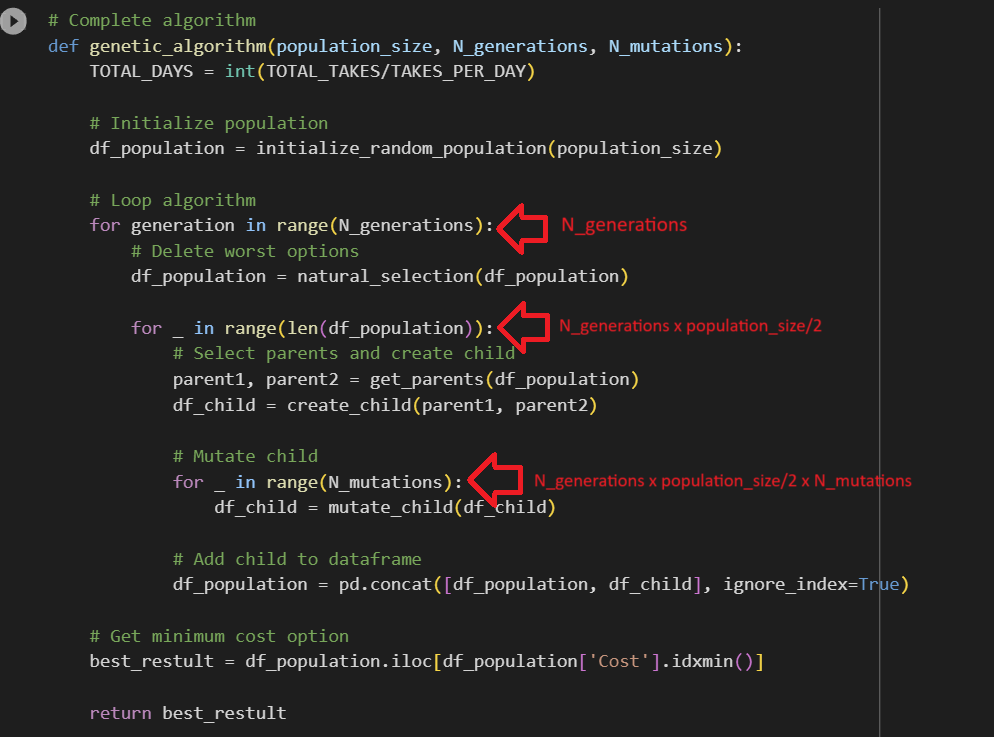

*Fig. 3 : Cálculo de complejidad del algoritmo*

Analizando el código del modelo, podemos concretar que la complejidad del algoritmo es la siguiente:

$$O(Number\ of\ Generations·Population\ Size·Number\ of\ Mutations)$$

Es por tanto un algoritmo polinómico, lo cual explicaría su mejora en tiempo de ejecución respecto el de fuerza bruta.

Según el problema (y tenga sentido), diseña un juego de datos de entrada aleatorios

Respuesta

Aplica el algoritmo al juego de datos generado

Respuesta

Enumera las referencias que has utilizado(si ha sido necesario) para llevar a cabo el trabajo

Respuesta

Describe brevemente las lineas de como crees que es posible avanzar en el estudio del problema. Ten en cuenta incluso posibles variaciones del problema y/o variaciones al alza del tamaño

Respuesta

Una de las posibles limitaciones del algoritmo genético planteado es la inicialización de los datos. En la propuesta, esta inicialización es aleatoria, resultando en unos datos iniciales poco deseables. Una opción para mejorar el programa sería utilizar como población inicial los resultados de otro algoritmo heurístico para conseguir aún mejores resultados.

Otra limitación es la creación de los hijos. En nuestro caso los hijos se generan con un cruce uniforme de los dos padres. Creo que se podría diseñar un método que pudiera escoger los mejores genes de los padres (días con coste bajo) y únicamente variar los genes peores (días con coste alto). Asimismo creo que también se podría hacer una selección inteligente sobre qué dias requieren variar el reparto de tomas.